In [107]:
import pandas as pd
import tarfile
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [108]:
rows = []
with tarfile.open('results-pywren.tar') as tf:
    print(tf.getnames())
    for name in filter(lambda name: name.endswith('.json'), tf.getnames()):
        print(name)
        fp = tf.extractfile(name)
        if fp is not None:
            content = fp.read().decode('utf-8')
            row = json.loads(content)
            row['name'] = name
            rows.append(row)

['results', 'results/run-2-pywren-5000mb-cold.json', 'results/run-4-pywren-3000mb-warm.json', 'results/run-3-pywren-5000mb-cold.txt', 'results/run-2-pywren-10000mb-cold.json', 'results/run-3-pywren-5000mb-warm.json', 'results/run-5-pywren-3000mb-cold.json', 'results/run-4-pywren-3000mb-warm.txt', 'results/run-4-pywren-10000mb-cold.txt', 'results/run-3-pywren-10000mb-cold.json', 'results/run-5-pywren-10000mb-warm.json', 'results/run-1-pywren-5000mb-warm.txt', 'results/run-3-pywren-3000mb-cold.json', 'results/run-2-pywren-5000mb-warm.json', 'results/run-5-pywren-5000mb-warm.txt', 'results/run-5-pywren-10000mb-cold.json', 'results/run-5-pywren-3000mb-warm.txt', 'results/run-3-pywren-5000mb-cold.json', 'results/run-3-pywren-10000mb-warm.json', 'results/run-1-pywren-3000mb-cold.json', 'results/run-4-pywren-10000mb-warm.json', 'results/run-3-pywren-3000mb-warm.txt', 'results/run-3-pywren-3000mb-cold.txt', 'results/run-1-pywren-10000mb-cold.json', 'results/run-4-pywren-10000mb-warm.txt', 'res

In [109]:
df = pd.DataFrame(rows)
df['run'] = df['name'].apply(lambda name: int(name.split('-')[1]))
df['size'] = df['name'].apply(lambda name: int(name.split('-')[3].replace('mb', '')))
df['type']= df['name'].apply(lambda name: name.split('-')[4].split('.')[0])

In [110]:
metrics = ['load_time',
      'run_time',
      'write_time',
      'job_time']
def task_stats(results):

    subdf = pd.DataFrame(results)

    return dict(zip(map(lambda name: name + '_task_mu', metrics), list(subdf[metrics].mean().values)))

In [111]:
df['tasks_stats'] = df['results'].apply(task_stats)
for m in metrics:
    key = m + '_task_mu'
    df[key] = df['tasks_stats'].apply(lambda x: x[key])

In [112]:
df.groupby(['size', 'type']).mean()

job_time  thereof_list_time  init_time  num_input_rows  \
size  type                                                            
3000  cold  34.695720           0.424732   0.021972     487441200.0   
      warm  21.421059           0.403278   0.019612     487441200.0   
5000  cold  33.529904           0.429627   0.020598     487441200.0   
      warm  30.007771           0.397351   0.019846     487441200.0   
10000 cold  32.729843           0.411741   0.019278     487441200.0   
      warm  25.152395           0.413808   0.019552     487441200.0   

            num_output_rows  num_input_files  run  load_time_task_mu  \
size  type                                                             
3000  cold        8580400.0            400.0  3.0           5.832865   
      warm        8580400.0            400.0  3.0           5.180634   
5000  cold        8580400.0            400.0  3.0           5.789715   
      warm        8580400.0            400.0  3.0           5.489751   
10000 cold        8580400.0            400.0  3.0           5.847425   
      warm        8580400.0            400.0  3.0           5.286914   

            run_time_task_mu  write_time_task_mu  job_time_task_mu  
size  type                                                          
3000  cold          2.343880            0.235370          8.412115  
      warm          2.334787            0.237924          7.753345  
5000  cold          2.345365            0.238132          8.373212  
      warm          2.345416            0.242347          8.077514  
10000 cold          2.347506            0.232722          8.427654  
      warm          2.341466            0.237095          7.865476

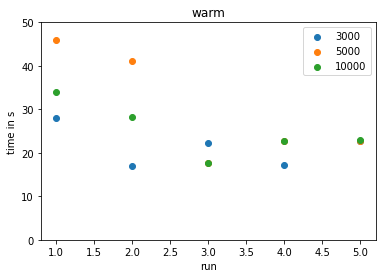

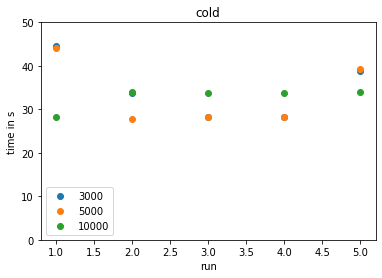

In [116]:
def plot_df(df, exp_type='warm'): 
    plt.figure()
    plt.title(exp_type)
    for group_name, group in df[df['type'] == exp_type].groupby('size'):

        #plt.plot(label=group_name)
        #print(group_name)
        group = group.sort_values('run')
        plt.scatter(group['run'], group['job_time'], label=group_name)
    plt.legend()
    plt.xlabel('run')
    plt.ylabel('time in s')

    plt.ylim(0, 50)
plot_df(df, 'warm')
plot_df(df, 'cold')

In [117]:
df[df['type'] == 'cold'].groupby('size').mean()

,job_time,thereof_list_time,init_time,num_input_rows,num_output_rows,num_input_files,run,load_time_task_mu,run_time_task_mu,write_time_task_mu,job_time_task_mu
size,,,,,,,,,,,
3000,34.695720,0.424732,0.021972,487441200.0,8580400.0,400.0,3.0,5.832865,2.343880,0.235370,8.412115
5000,33.529904,0.429627,0.020598,487441200.0,8580400.0,400.0,3.0,5.789715,2.345365,0.238132,8.373212
10000,32.729843,0.411741,0.019278,487441200.0,8580400.0,400.0,3.0,5.847425,2.347506,0.232722,8.427654


In [118]:
df[(df['type'] == 'warm') & (df['run'] > 1)].groupby('size').mean()

,job_time,thereof_list_time,init_time,num_input_rows,num_output_rows,num_input_files,run,load_time_task_mu,run_time_task_mu,write_time_task_mu,job_time_task_mu
size,,,,,,,,,,,
3000,19.786993,0.402642,0.018859,487441200.0,8580400.0,400.0,3.5,5.022281,2.332143,0.238454,7.592878
5000,26.035232,0.390083,0.019076,487441200.0,8580400.0,400.0,3.5,5.050753,2.337763,0.242417,7.630933
10000,22.925207,0.408347,0.019202,487441200.0,8580400.0,400.0,3.5,5.025586,2.339868,0.237155,7.602609
